<a href="https://colab.research.google.com/github/AndrewSchoeller/BERT-for-RRC-ABSA/blob/master/Kopie_von_sequence_classification_asc_BERT_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install wget

     |████████████████████████████████| 2.3MB 28.2MB/s 
     |████████████████████████████████| 901kB 45.5MB/s 
     |████████████████████████████████| 3.3MB 47.6MB/s 
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=0829f8f05a0d66af718042c19a89f8412f8a8310508c0f1db34dba2061200dad
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
# Datenvorbereitung
import json
import wget

# download and open json file
url = 'https://raw.githubusercontent.com/Johannes96/BERT_fineTune/master/data/final_train_asc_CLS.json'
dataset1 = wget.download(url)

with open(dataset1) as json_file:
    train_asc = json.load(json_file)

url = 'https://raw.githubusercontent.com/Johannes96/BERT_fineTune/master/data/final_dev_asc_CLS.json'
dataset2 = wget.download(url)

with open(dataset2) as json_file:
    dev_asc = json.load(json_file)

# Extrahiere sentences und labels aus den Daten
train_texts = []
train_labels_temp = []
for i in train_asc:
    train_labels_temp.append(train_asc[i]['polarity'])
    train_texts.append(train_asc[i]['sentence'])

dev_texts = []
dev_labels_temp = []
for i in dev_asc:
    dev_labels_temp.append(dev_asc[i]['polarity'])
    dev_texts.append(dev_asc[i]['sentence'])

# Ersetzte labels durch Nummern von 0 bis 4
train_labels = []
for i in train_labels_temp:
    if i == 'str_negative':
        train_labels.append(0)
    elif i == 'negative':
        train_labels.append(1)
    elif i == 'neutral':
        train_labels.append(2)
    elif i == 'positive':
        train_labels.append(3)
    elif i == 'str_positive':
        train_labels.append(4)

dev_labels = []
for i in dev_labels_temp:
    if i == 'str_negative':
        dev_labels.append(0)
    elif i == 'negative':
        dev_labels.append(1)
    elif i == 'neutral':
        dev_labels.append(2)
    elif i == 'positive':
        dev_labels.append(3)
    elif i == 'str_positive':
        dev_labels.append(4)

# Verreinige Listen zu einem Datensatz
texts = train_texts
labels = train_labels
labels.extend(dev_labels)
texts.extend(dev_texts)

# Teile in Trainings- und Testdaten auf
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=.2)


In [ ]:
# Load Tokenizer
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

# Tokenizing der Trainings- und Testdaten
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
# test_encodings = tokenizer(dev_texts, truncation=True, padding=True)

# erstelle Datensätze
import torch

class ASCDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ASCDataset(train_encodings, train_labels)
val_dataset = ASCDataset(val_encodings, val_labels)
# test_dataset = ASCDataset(test_encodings, dev_labels)

# Anpassung von DistilBERT sodass er mit 5 labels funktioniert
from transformers import DistilBertForSequenceClassification, DistilBertConfig, Trainer, TrainingArguments
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased')

config = DistilBertConfig.from_pretrained('distilbert-base-cased')
config.num_labels = 5 # adjust to change number of distinct labels (y)
model = DistilBertForSequenceClassification(config)
# print(model.parameters) # show how many labels (out_features = ___) are defined

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bia

In [ ]:
# Trainingsphase
trainer.train()

Step,Training Loss
50,1.487900
100,1.406000
150,1.444200
200,1.420200
250,1.395800
300,1.391300
350,1.372600
400,1.345200
450,1.382000
500,1.247300


TrainOutput(global_step=1377, training_loss=1.1489190438907044, metrics={'train_runtime': 304.0707, 'train_samples_per_second': 4.529, 'total_flos': 290133124694700.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 2326994944, 'init_mem_gpu_alloc_delta': 263666176, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 11366400, 'train_mem_gpu_alloc_delta': 812377600, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 859909120})

In [ ]:
trainer.evaluate()

{'epoch': 3.0,
 'eval_loss': 1.0757726430892944,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 265030144,
 'eval_runtime': 6.8817,
 'eval_samples_per_second': 266.649}

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-51543a5b-be3f-df53-2149-17900809320d)


In [ ]:
import numpy as np

text1 = val_texts
label1 = val_labels
tokenized_texts = tokenizer(text1, truncation=True, padding=True)

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

test_dataset = SimpleDataset(tokenized_texts)
predictions = trainer.predict(test_dataset)

# Erstelle Liste mit prognostizierten Labels
pred_labels = []
for i, pred in enumerate(predictions.predictions):
  pred_labels.append(np.where(pred == np.amax(pred))[0][0])

In [ ]:
# Berechne Metriken MSE, Confusion-Martix und F1-Score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

mse = mean_squared_error(val_labels, pred_labels)
accuracy = accuracy_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels, average='macro') # zu klären welcher average-Wert verwendet werden soll
conf_matrix = confusion_matrix(val_labels, pred_labels)

print('MSE:', mse)
print('Accuracy:', accuracy)
print('F1-Score:', f1)
print('Confusion Matrix:\n', conf_matrix)

MSE: 1.2599455040871934
Accuracy: 0.5814713896457766
F1-Score: 0.43068561464410005
Confusion Matrix:
 [[ 43 100   0  22  26]
 [ 18 201   0  60  25]
 [  0  49   0  36  18]
 [  3  63   0 383 164]
 [  5  32   0 147 440]]


In [ ]:
import pandas as pd

y_actual = pd.Series(val_labels, name='Actual')
y_pred = pd.Series(pred_labels, name='Predicted')

df_confusion = pd.crosstab(y_actual, y_pred)
print(df_confusion)

df_conf_norm = df_confusion / df_confusion.sum(axis=1)
print(df_conf_norm)

Predicted   0    1    3    4
Actual                      
0          43  100   22   26
1          18  201   60   25
2           0   49   36   18
3           3   63  383  164
4           5   32  147  440
               0         1   2         3         4
Actual                                            
0       0.225131  0.328947 NaN  0.035889  0.041667
1       0.094241  0.661184 NaN  0.097879  0.040064
2       0.000000  0.161184 NaN  0.058728  0.028846
3       0.015707  0.207237 NaN  0.624796  0.262821
4       0.026178  0.105263 NaN  0.239804  0.705128


Text(0.5, 69.0, 'Predicted')

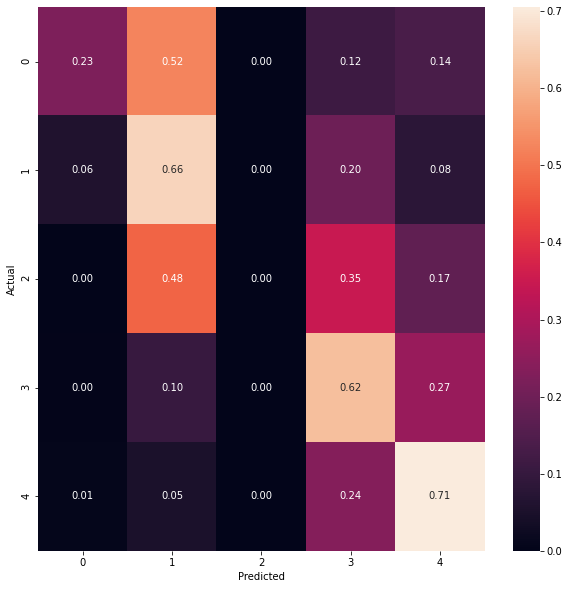

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

labels = ['str neg', 'neg', 'neutral', 'pos', 'str pos']
cm = confusion_matrix(val_labels, pred_labels)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')